In [1]:
from utils import *

from glob import glob
from tqdm import tqdm

import math

import csv
from csv import reader

# Utils

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
def center_of_mass(points):
    com = [0, 0]
    
    for point in points:
        com = [com[0] + point[0], com[1] + point[1]]
    com = [math.floor(com[0] / len(points)), math.floor(com[1] / len(points))]
    
    return com

In [4]:
def l_2_distance(point_1, point_2):
    
    return math.sqrt(math.pow(point_2[0] - point_1[0], 2) + math.pow(point_2[1] - point_1[1], 2))

In [5]:
def index_class(class_name):
    
    if class_name == "'BottleCap_FaceDown'":
        return 0
    elif class_name == "'BottleCap_FaceUp'":
        return 1
    elif class_name == "'BottleCap_Deformed'":
        return 2
    else:
        return -1 #error

In [6]:
def count_records(csv_lines):
    
    counter = [0, 0, 0]
    
    for line in csv_lines:
        counter[index_class(line[3])] += 1
    
    return counter

In [7]:
def eval_predictions(gts_, predictions_):
        
    gts = gts_.copy()
    predictions = predictions_.copy()
    y_test_ = []
    y_pred_ = []
    missed_ = [0, 0, 0]
    extra_ = [0, 0, 0]
    max_dist = 20
    dists_ = []
    
    missing_predictions = False
    for i in range(len(gts)):
        
        gt = gts[i]
        #print("GT:", gt)
        
        if (len(predictions) > 0):
            # predictions is not empty
            # find closest pred based on center of mass l_2 distance
            gt_com = [int(gt[1]), int(gt[2])]
            min_dist = float("inf")
            found = False
            for i, pred in enumerate(predictions):
                pred_com = [int(pred[1]), int(pred[2])]
                dist = l_2_distance(gt_com, pred_com)
                if dist < min_dist and dist < max_dist:
                    closest_pred = pred
                    index_closest_pred = i
                    min_dist = dist
                    found = True
            
            if found: # gt has a corresponding prediction
                pred = closest_pred
                dists_.append(min_dist)

                y_test.append(index_class(gt[3]))
                y_pred.append(index_class(pred[3]))

                del predictions[index_closest_pred]
                
            else: # gt hasn't a corresponding prediction
                missed_[index_class(gt[3])] += 1
        else: 
            # predictions is empty
            missing_predictions = True
            last_gt_index = i
            break
        
    if missing_predictions:
        for j in range(i, len(gts)):
            gt = gts[j]
            missed_[index_class(gt[3])] += 1
            
    # if there are still elements in predictions, it means
    # that something other than what is in the ground truth 
    # has been detected
    extra_ = count_records(predictions)
    
    return y_test_, y_pred_, missed_, extra_, dists_

# Main

In [11]:
images_paths = glob('../dataset/images/*.png')
# images_paths = images_paths[:10]

gt_counters = [0, 0, 0]
pred_counters = [0, 0, 0]
y_test = []
y_pred = []
missed = [0, 0, 0]
extra = [0, 0, 0]
dists = []
logs = []

for file_index, image_path in enumerate(images_paths):

    image_path = images_paths[file_index]
    file_name = image_path.split("\\")[-1].split(".")[0]
    file_number = int(image_path.split('_')[-1].split('.')[0])
    
    # read ground truth
    # read csv file as a list of lists
    with open('../dataset/gt_csv/'+ file_name + '.csv', 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Pass reader object to list() to get a list of lists
        gts = list(csv_reader)
    # print("GT: ", gts)

    with open('../test_modules/test_object_detection/results/'+ file_name + '.csv', 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Pass reader object to list() to get a list of lists
        predictions = list(csv_reader)
    # print("PRED: ", predictions)
    
    # update global counter of records
    gt_counters_ = count_records(gts)
    pred_counters_ = count_records(predictions)
    for i in range(3):
        gt_counters[i] += gt_counters_[i]
        pred_counters[i] += pred_counters_[i]
    
    # eval predictions
    yt, yp, mc, ec, ds = eval_predictions(gts, predictions)
    
    y_test = y_test + yt
    y_pred = y_pred + yp
    missed = [missed[0] + mc[0], missed[1] + mc[1], missed[2] + mc[2]]
    extra = [extra[0] + ec[0], extra[1] + ec[1], extra[2] + ec[2]]
    dists = dists + ds
    
    log = file_name + " missed: " + str(mc) + " extra: " + str(ec)
    logs.append(log)
    print(log)

CV20_image_1 missed: [0, 0, 1] extra: [0, 0, 0]
CV20_image_10 missed: [0, 0, 0] extra: [0, 0, 0]
CV20_image_100 missed: [0, 0, 0] extra: [0, 0, 0]
CV20_image_101 missed: [1, 0, 0] extra: [0, 0, 0]
CV20_image_102 missed: [1, 0, 1] extra: [0, 0, 0]
CV20_image_103 missed: [0, 0, 0] extra: [0, 0, 0]
CV20_image_104 missed: [0, 0, 1] extra: [0, 0, 0]
CV20_image_105 missed: [0, 0, 0] extra: [0, 0, 0]
CV20_image_106 missed: [0, 0, 0] extra: [0, 0, 0]
CV20_image_107 missed: [4, 1, 0] extra: [0, 0, 0]
CV20_image_108 missed: [0, 0, 0] extra: [0, 0, 1]
CV20_image_109 missed: [0, 1, 0] extra: [0, 0, 0]
CV20_image_11 missed: [0, 0, 0] extra: [0, 0, 0]
CV20_image_110 missed: [0, 0, 0] extra: [0, 0, 0]
CV20_image_111 missed: [0, 0, 0] extra: [5, 1, 2]
CV20_image_112 missed: [0, 0, 0] extra: [1, 0, 0]
CV20_image_113 missed: [0, 0, 1] extra: [0, 0, 0]
CV20_image_114 missed: [0, 0, 1] extra: [0, 0, 0]
CV20_image_115 missed: [0, 0, 0] extra: [0, 0, 0]
CV20_image_116 missed: [0, 0, 0] extra: [0, 0, 0]
CV20

In [12]:
gt_counters, missed

([646, 247, 210], [61, 36, 52])

In [13]:
pred_counters, extra

([660, 238, 182], [57, 36, 33])

In [14]:
print("Missed FaceDown: ", round(missed[0] / gt_counters[0] * 100, 2), "%")
print("Extra FaceDown:", round(extra[0] / pred_counters[0] * 100, 2), "%")
print("Missed FaceUp: ", round(missed[1] / gt_counters[1] * 100, 2), "%")
print("Extra FaceUp:", round(extra[1] / pred_counters[1] * 100, 2), "%")
print("Missed Deformed: ", round(missed[2] / gt_counters[2] * 100, 2), "%")
print("Extra Deformed:", round(extra[2] / pred_counters[2] * 100, 2), "%")

Missed FaceDown:  9.44 %
Extra FaceDown: 8.64 %
Missed FaceUp:  14.57 %
Extra FaceUp: 15.13 %
Missed Deformed:  24.76 %
Extra Deformed: 18.13 %


In [15]:
# average distance between gt center of mass [com] and predicted com 
sum(dists) / len(dists) 

4.98683793088351

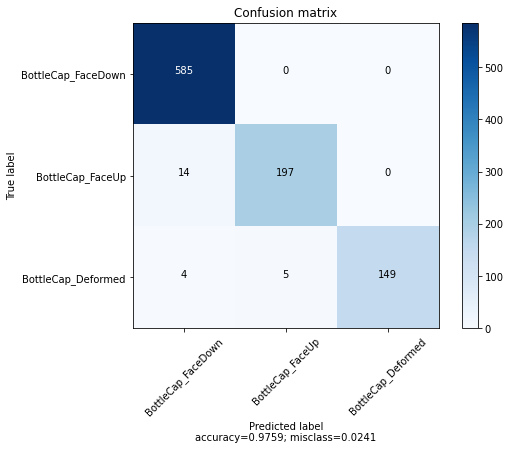


Accuracy: 0.98

Micro Precision: 0.98
Micro Recall: 0.98
Micro F1-score: 0.98

Macro Precision: 0.98
Macro Recall: 0.96
Macro F1-score: 0.97

Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98

Classification Report

              precision    recall  f1-score   support

     Class 1       0.97      1.00      0.98       585
     Class 2       0.98      0.93      0.95       211
     Class 3       1.00      0.94      0.97       158

    accuracy                           0.98       954
   macro avg       0.98      0.96      0.97       954
weighted avg       0.98      0.98      0.98       954



In [16]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)

class_names = ['BottleCap_FaceDown', 'BottleCap_FaceUp', 'BottleCap_Deformed']
plot_confusion_matrix(confusion,
                      target_names=class_names,
                      cmap=plt.cm.Blues)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))